In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [2]:
#Accesses .csv file in case of network emergencies

import numpy as np
import pylab as pl
from scipy.signal import savgol_filter

data = np.genfromtxt('delayMeanSixMonths.csv',delimiter=',',skip_header = 1)
epochTime = data[:,0]
delayMean = data[:,1]

#Get times that have values
indices = np.logical_not(np.isnan(delayMean))
delayMean = delayMean[indices]
epochTime = epochTime[indices]
monthTime = epochTime/(1000*60*60*24*30)

First task: analyzing the stability of one link, the CERN/BNL link.

First a query is constructed to load the latency data from the CERN/BNL link. This is taken over a 6-month period, binned daily.

In [3]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

query1 = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "srcSite:CERN* AND destSite:BNL* AND delay_mean:>0", #Some delay values were negative (!)
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1452612045688,
                  "lte": 1468333245688,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "3": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1d",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1452612045687,
          "max": 1468333245687
        }
      },
      "aggs": {
        "2": {
          "avg": {
            "field": "delay_mean"
          }
        }
      }
    }
  }
}

#Get delay 
response = es.search(index="network_weather_2-*", body=query1, request_timeout=600)

The delay values and associated timestamps are then filtered to exclude periods without data.

In [4]:
delayMean = []
epochTime = []
for r in response['aggregations']['3']['buckets']:
    #Get field value and timestamp
    delayMean.append(r['2']['value'])
    epochTime.append(r['key'])

#Get times that have values
delayMean = np.array(delayMean)
epochTime = np.array(epochTime)

indices = np.logical_not(np.isnan(delayMean))

delayMean = delayMean[indices]
epochTime = epochTime[indices]

#Convert 
monthTime = epochTime/(1000*60*60*24*30)

#Filter outliers
#filterOutliers = 2*np.std(delayMean)
#centered = delayMean - np.mean(delayMean)
#indices2 = np.abs(centered) < filterOutliers

#delayMean = delayMean[indices2]
#monthTime = monthTime[indices2]

The cell below grabs 70% of the total dataset as a random sample to perform linear regression. Then the remaining 30% is compared to the linear fit, and the root-mean-squared error is reported. This process is repeated several times, each time grabbing new random samples for the training and test set, while maintaining the same 70/30 ratio.
The results are graphed.

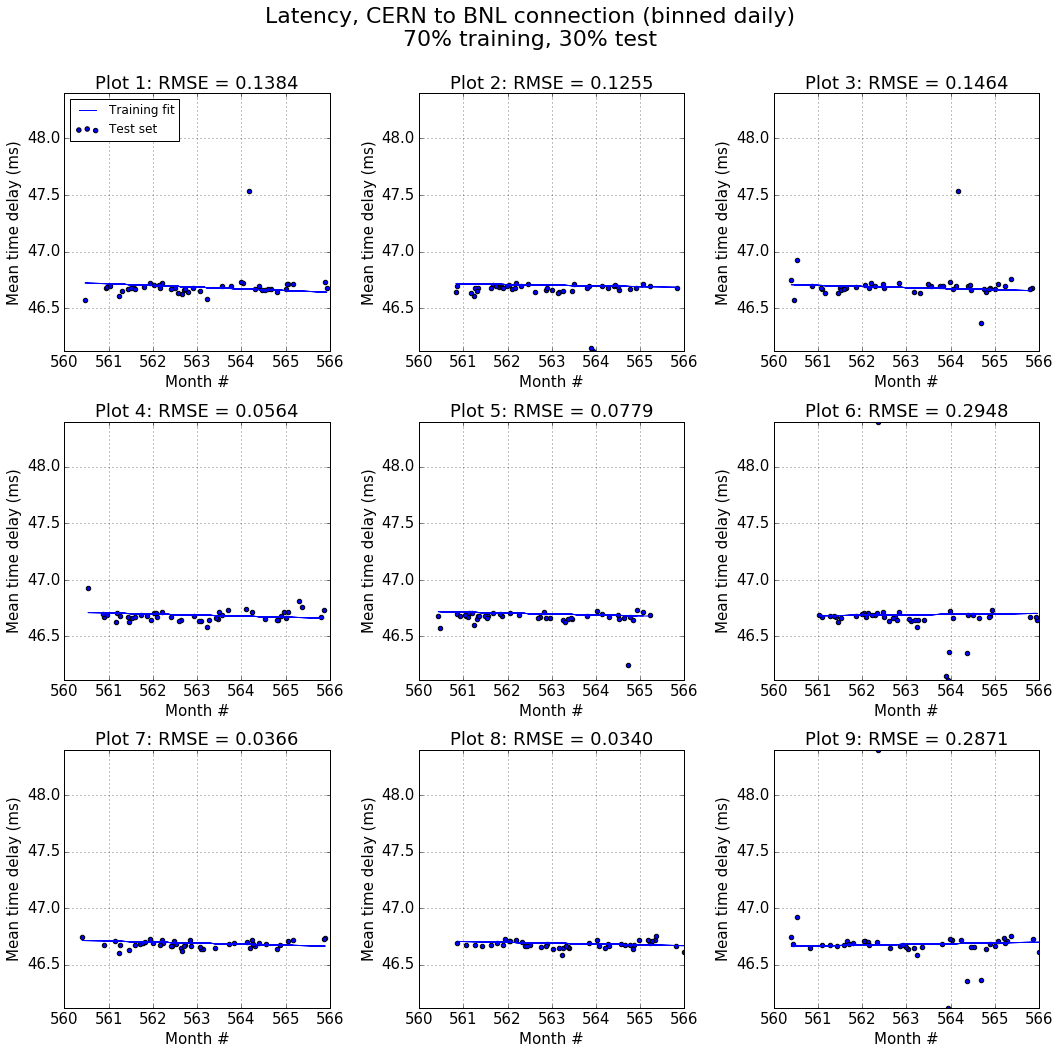

In [5]:
import matplotlib.pyplot as plt
from sklearn import cross_validation,linear_model
import matplotlib.dates as dt

xTrainSamples = []
xTestSamples = []
yTrainSamples = []
yTestSamples = []
regressionSet = []


coefficientSet = []
rmseSet = []
varianceSet = []

plt.figure(figsize=(15,15))
for i in range(9):
    
    #Build training sets, randomly sampled from data; reseeded based on index
    xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(monthTime,delayMean,
                                                                        test_size=0.3,random_state = i)
    #Reshape for LinearRegression function
    xTrain = xTrain.reshape(-1,1)
    xTest = xTest.reshape(-1,1)
    # Create linear regression object
    regr = linear_model.LinearRegression(fit_intercept=True)
    # Train the model using the training sets
    regr.fit(xTrain, yTrain)
    
    
    coefficientSet.append(regr.coef_)
    regressionSet.append(regr)
    
    #Get mean squared error and store it
    rmseSet.append(np.sqrt(np.mean((regr.predict(xTest) - yTest) ** 2)))
    
    #Get variance and store it
    varianceSet.append(regr.score(xTest, yTest))
    xTrainSamples.append(xTrain)
    xTestSamples.append(xTest)
    yTrainSamples.append(yTrain)
    yTestSamples.append(yTest)
    
    yPredict = regr.predict(xTest)
    #Plot test sample with predicted line
    plt.subplot(3,3,i+1)
    plt.plot(xTest, yPredict, color='blue',
         linewidth=1,label='Training fit')

    plt.title('Plot %i: RMSE = %.4f'%(i+1,rmseSet[i]))
    plt.scatter(xTest,yTest,label='Test set')
    if i ==0:
        plt.legend(loc=2,prop={'size':12})
    plt.ylabel('Mean time delay (ms)')
    plt.xlabel('Month #')
    plt.ylim(delayMean.min(),delayMean.max())
    plt.xlim(560,566)
    plt.grid()

plt.suptitle('Latency, CERN to BNL connection (binned daily)\n70% training, 30% test',size=22)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

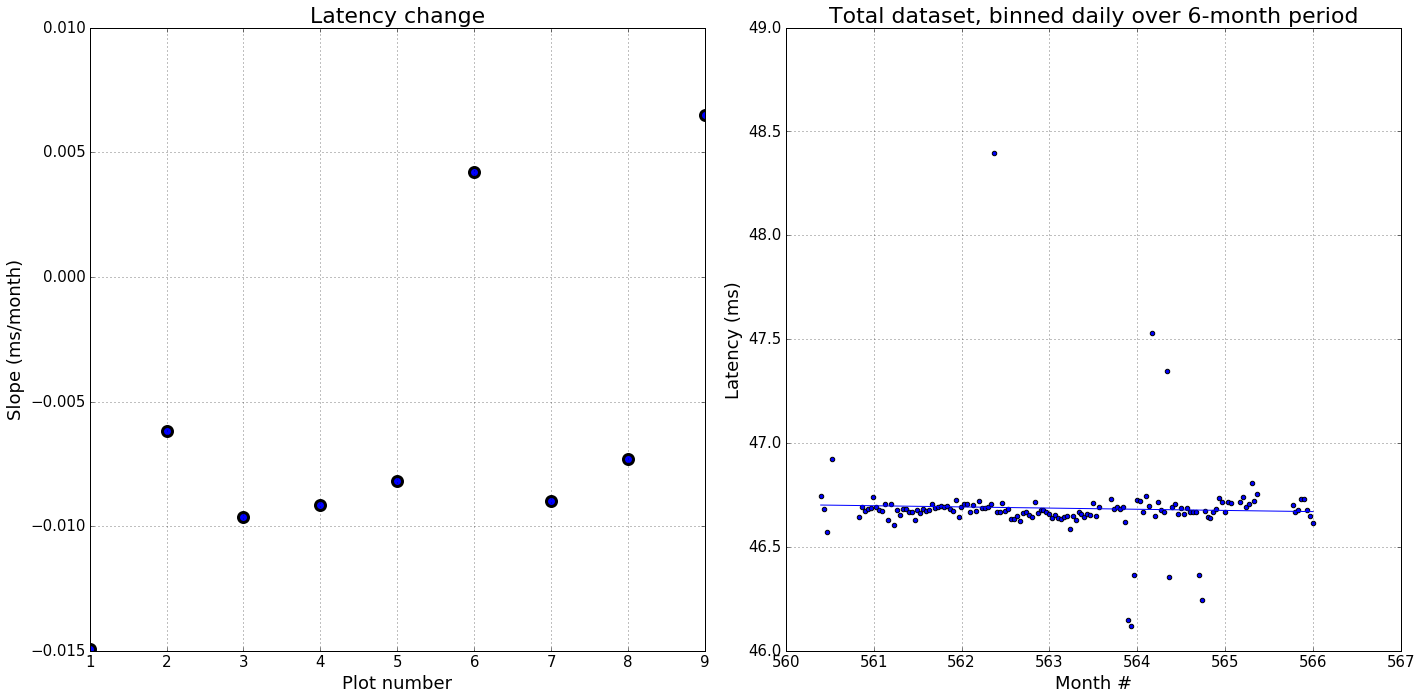

In [6]:
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
monthTime = monthTime.reshape(-1,1)
regr.fit(monthTime, delayMean)
yPredict = regr.predict(monthTime)

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.plot(range(1,10),coefficientSet,'bo',mew=3,ms=10)
plt.xlim(1,9)
plt.xlabel('Plot number',size=18)
plt.ylabel('Slope (ms/month)',size=18)
plt.grid()
plt.title('Latency change',size=22)


plt.subplot(122)
plt.scatter(monthTime,delayMean)
plt.plot(monthTime, yPredict, color='blue',
     linewidth=1,label='Training fit')
plt.title('Total dataset, binned daily over 6-month period',size=22)
plt.xlabel('Month #',size=18)
plt.ylabel('Latency (ms)',size=18)
plt.grid()
plt.tight_layout()

So indeed, the CERN/BNL link is quite stable.

Next, we want to produce a summary graph displaying the latency stability for all destination sites connected to CERN. To do this, we first get a list of site names.

In [7]:
query2 = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False,
          "query": "srcSite:CERN* AND destSite:*  AND delay_mean:>0"
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1452612045688,
                  "lte": 1468333245688,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "3": {
      "terms": {
        "field": "destSite",
        "size": 81,
        "order": {
          "2": "desc"
        }
      },
      "aggs": {
        "2": {
          "avg": {
            "field": "delay_mean"
          }
        },
        "4": {
          "avg": {
            "field": "delay_sd"
          }
        }
      }
    }
  }
}
response = es.search(index="network_weather_2-*", body=query2, request_timeout=600)

In [8]:
linkName = []
for r in response['aggregations']['3']['buckets']:
    #Get field value and timestamp
    linkName.append(r['key'])
print(linkName)

['Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE', 'T2-TH-CUNSTDA', 'EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2', 'ITEP', 'SFU-LCG2', 'TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2', 'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE', 'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt', 'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI', 'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1', 'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI', 'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN', 'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH', 'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC', 'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW', 'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF', 'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP', 'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP', 'UKI-

Next, get time series data and latency values associated with each link, over a six-month period (binned daily).

In [9]:
import ast

totalHistData = []
totalEpochTime = []
for i in range(len(linkName)):
    query3 = '''{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "srcSite:CERN* AND destSite:%s* AND delay_mean:>0",
              "analyze_wildcard": True,
              "lowercase_expanded_terms": False
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": 1452689502533,
                      "lte": 1468410702533,
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "1d",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": 1452689502532,
              "max": 1468410702533
            }
          },
          "aggs": {
            "1": {
              "avg": {
                "field": "delay_mean"
              }
            }
          }
        }
      }
    }'''
    query3 = ast.literal_eval(query3%(linkName[i]))
    response = es.search(index="network_weather_2-*", body=query3, request_timeout=600)
    #print(response)
    delayMean = []
    epochTime = []

    for r in response['aggregations']['2']['buckets']:
        #Get field value and timestamp
        delayMean.append(r['1']['value'])
        epochTime.append(r['key'])
        
    #Get times that have values
    delayMean = np.array(delayMean)
    epochTime = np.array(epochTime)

    indices = np.logical_not(np.isnan(delayMean))

    delayMean = delayMean[indices]
    epochTime = epochTime[indices]
    
    totalHistData.append(delayMean)
    totalEpochTime.append(epochTime)

The resultant data may be displayed as box plots, giving an idea of the underlying distribution of the latency for each link.

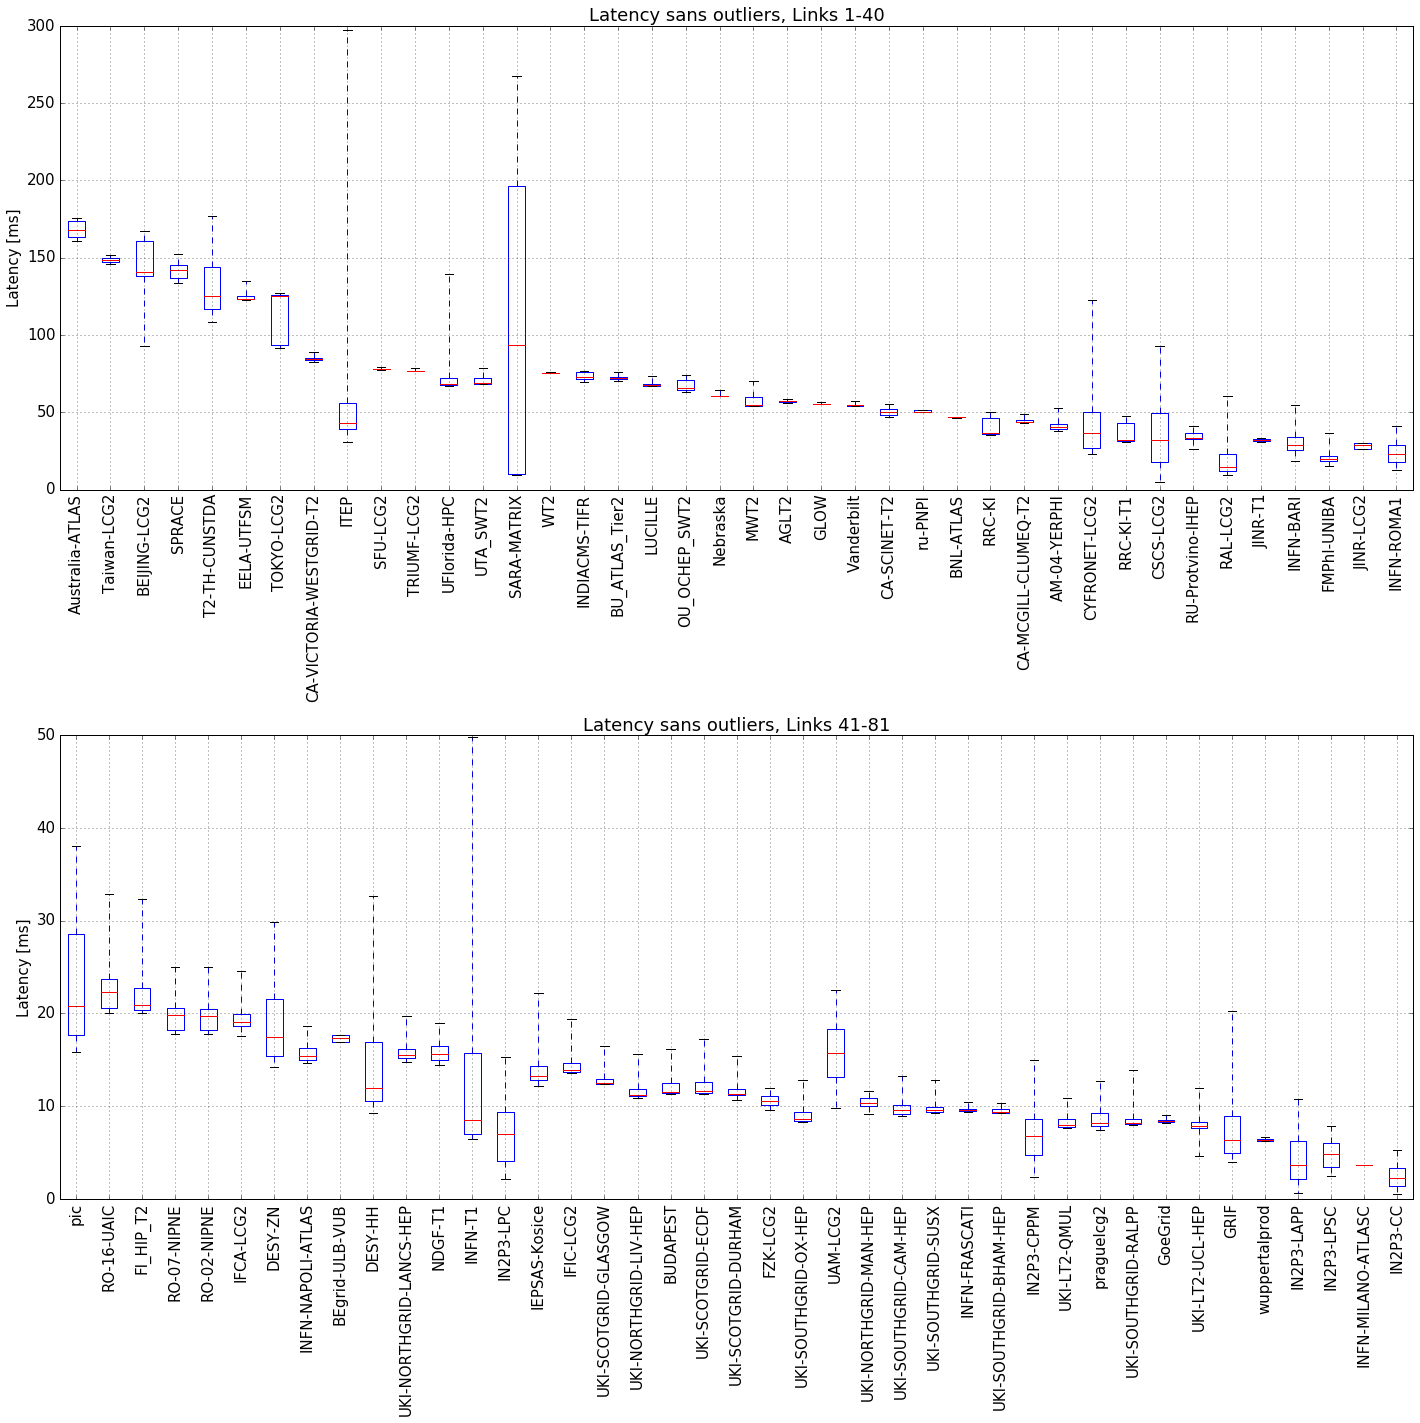

In [10]:
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(totalHistData[0:40], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Latency [ms]')
plt.title('Latency sans outliers, Links 1-40')

plt.subplot(212)
plt.boxplot(totalHistData[40:], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Latency [ms]')
plt.title('Latency sans outliers, Links 41-81')
plt.grid()

plt.tight_layout()

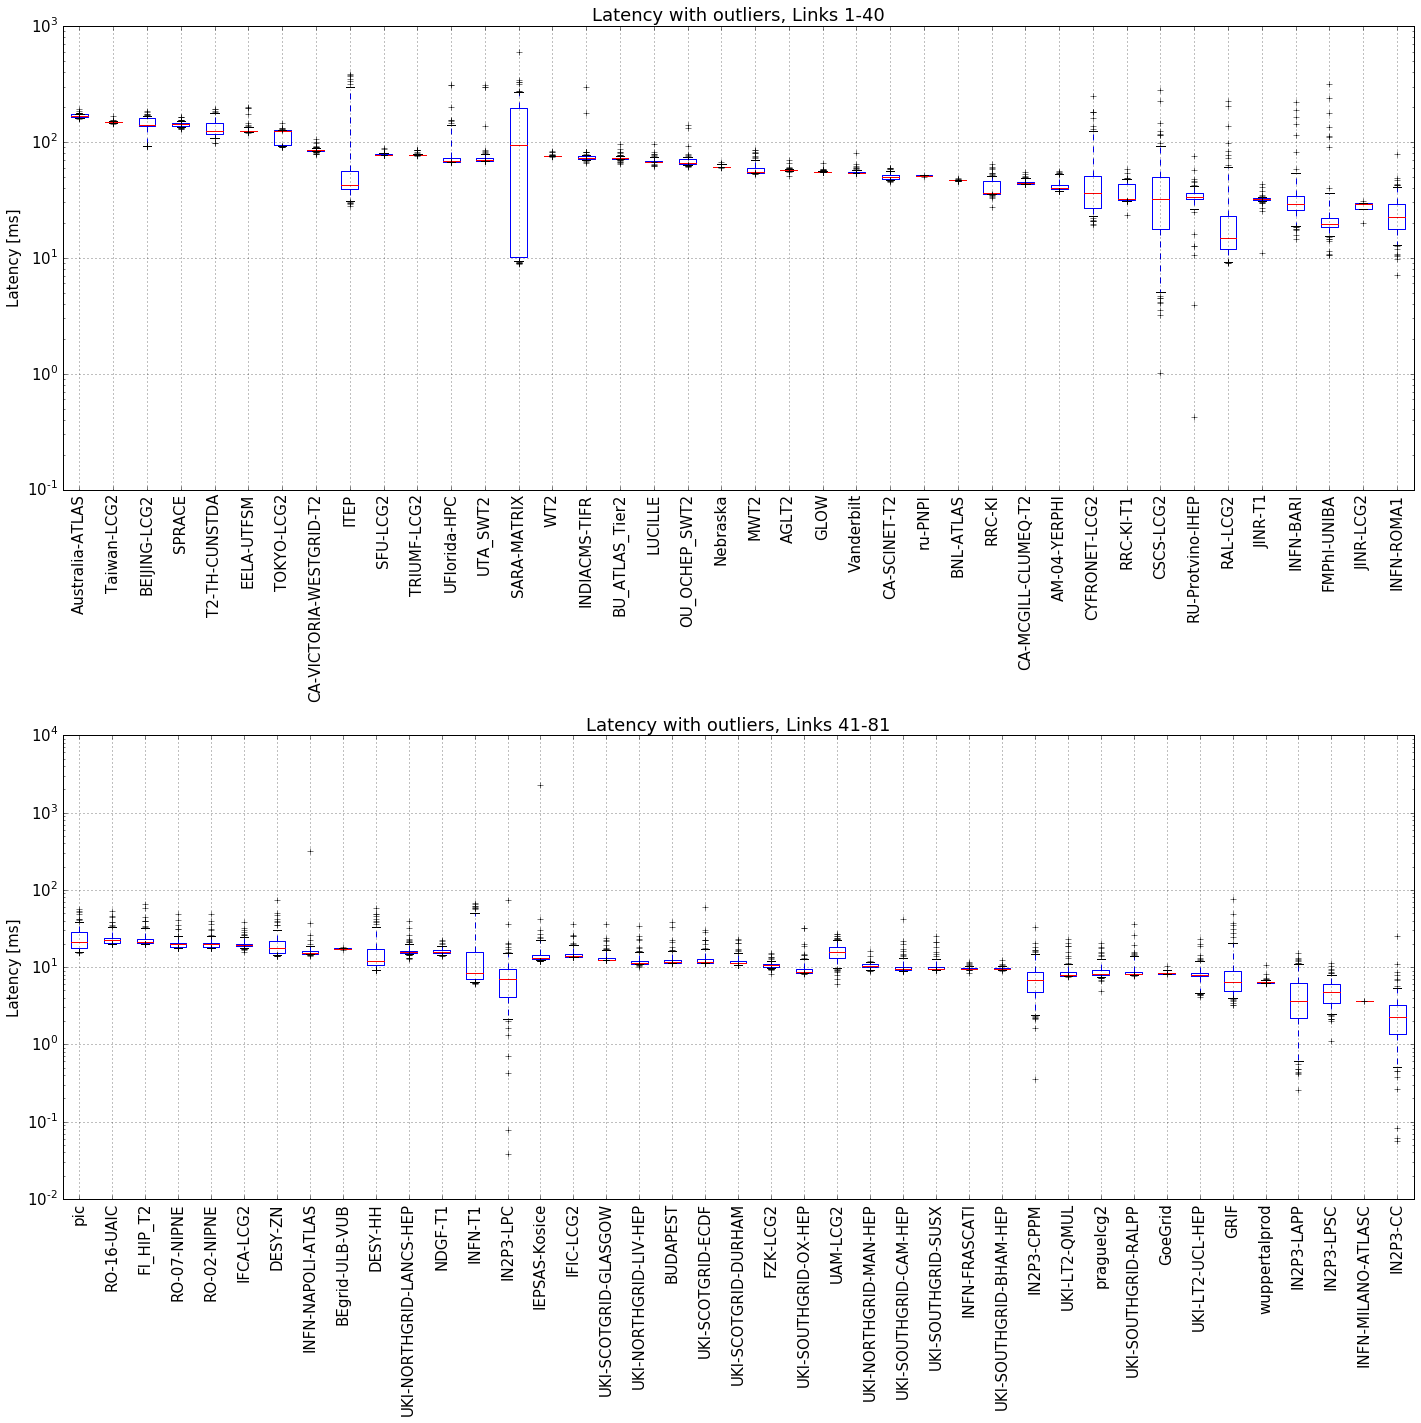

In [11]:
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(totalHistData[0:40], whis=[5,95],showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
ax.set_yscale('log')
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Latency [ms]')
plt.title('Latency with outliers, Links 1-40')

plt.subplot(212)
plt.boxplot(totalHistData[40:], whis=[5,95],showfliers=True)
ax = plt.gca()
ax.set_yscale('log')
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Latency [ms]')
plt.title('Latency with outliers, Links 41-81')
plt.grid()

plt.tight_layout()

In [12]:
histData= dict(zip(linkName, totalHistData))
histTime = dict(zip(linkName, totalEpochTime))

The SARA-MATRIX link looks quite unstable, let's look at the time series data.

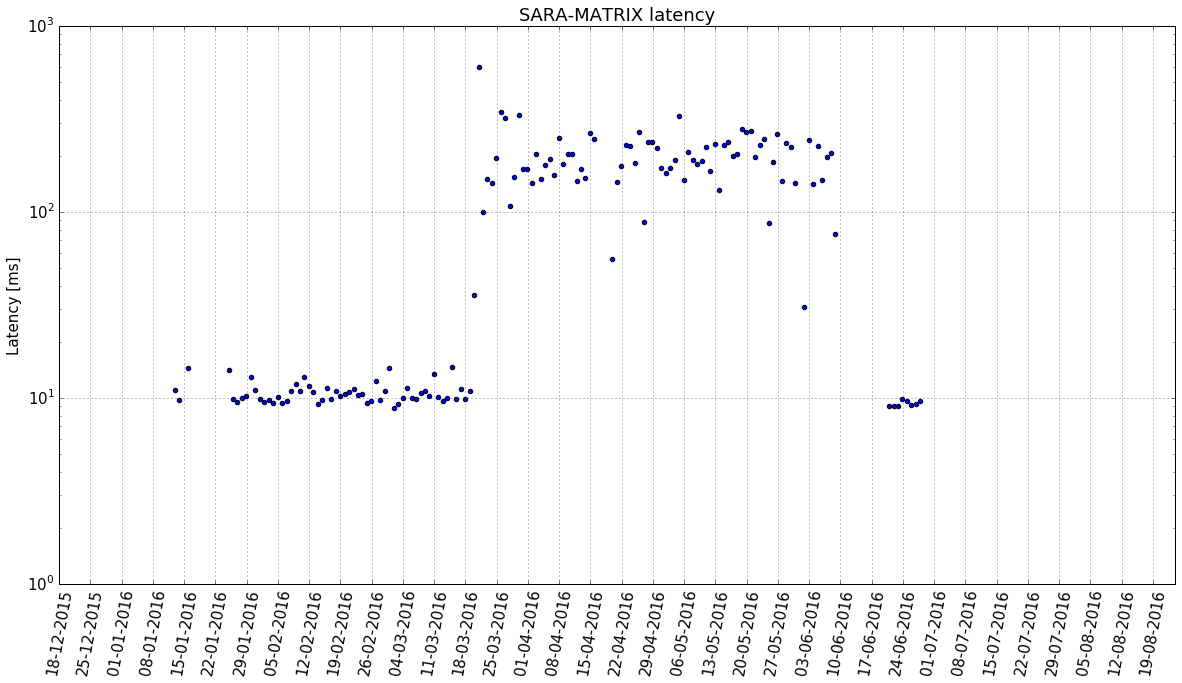

In [14]:
centerName = 'SARA-MATRIX'

timestamp = dt.epoch2num(histTime[centerName]/1000.)
latency = histData[centerName]

plt.figure(figsize=(20,10))
plt.scatter(timestamp,latency)

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

ax.set_yscale('log')
plt.ylabel('Latency [ms]')

#Manually add extra ticks to histogram plots
ticks = 7
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.grid()
plt.title('SARA-MATRIX latency')
plt.show()